## INTRODUCCIÓN
Con un enfoque metodológico que integra tanto el aprendizaje no supervisado como el supervisado, hemos implementado el algoritmo K-Means para segmentar las viviendas en clusters significativos. Posteriormente, validamos y refinamos nuestra solución con un modelo de clasificación supervisada, asegurando que nuestras conclusiones sean robustas y aplicables a datos nuevos y no vistos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
import folium
from scipy.stats import gaussian_kde
from sklearn.tree import DecisionTreeClassifier
from joblib import dump
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv')
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
df = df.drop(['HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal'], axis=1)
df.head(5)

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [4]:
# Dividimos en entrenamiento y prueba
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
# Escalamos los datos
# Inicializamos el escalador
scaler = StandardScaler()

# Ajustamos el escalador solo en los datos de entrenamiento y transformamos el conjunto de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertimos de nuevo a DataFrames para poder asignar las columnas
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [6]:
# Ajustar el modelo K-Means con 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_train)

# Agregar la asignación de clusters al conjunto de entrenamiento
X_train['cluster'] = kmeans.labels_

# Ahora, usar el modelo entrenado para predecir los clusters del conjunto de prueba
X_test['cluster'] = kmeans.predict(X_test)

In [7]:
X_train['cluster'].head(10)

14196    3
8267     3
17445    1
14265    3
2271     5
17848    0
6252     3
9389     0
6113     3
6061     1
Name: cluster, dtype: int32

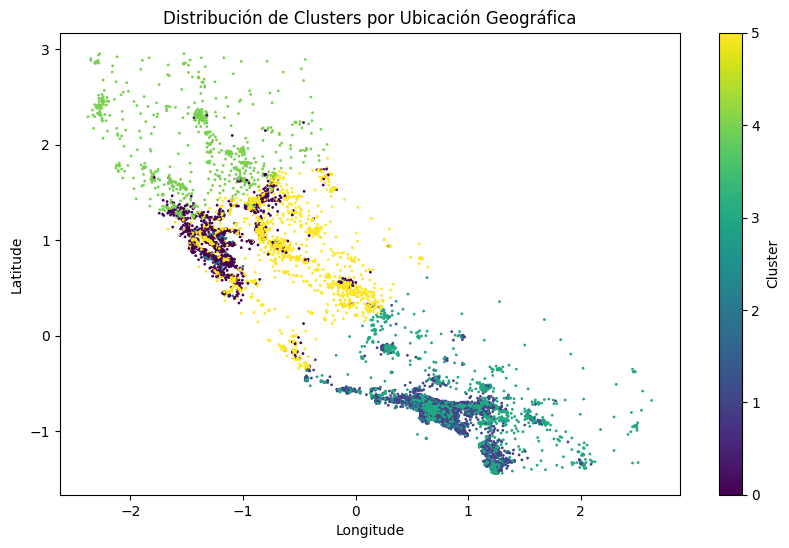

In [8]:
# Visualizamos
plt.figure(figsize=(10, 6))
plt.scatter(X_train['Longitude'], X_train['Latitude'], c=X_train['cluster'], cmap='viridis', s=1)
plt.colorbar(label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribución de Clusters por Ubicación Geográfica')
plt.show()

In [9]:
# Extraer los centroides
centroids = kmeans.cluster_centers_

# Crear un DataFrame con los centroides para una mejor interpretación
centroids_df = pd.DataFrame(centroids, columns=['Latitude', 'Longitude', 'MedInc'])

# Mostrar los centroides
print(centroids_df)

# Adicionalmente, si deseas obtener estadísticas detalladas de los ingresos medios (MedInc) por cluster:
income_stats_per_cluster = X_train.groupby('cluster')['MedInc'].describe()
print(income_stats_per_cluster)

   Latitude  Longitude    MedInc
0  0.782050   0.980322 -1.185961
1  0.704670  -0.828567  0.774592
2  3.371039  -0.355545  0.182350
3 -0.609941  -0.803582  0.826053
4 -0.771012   1.869967 -1.403010
5 -0.561038   0.896130 -0.837646
          count      mean       std       min       25%       50%       75%  \
cluster                                                                       
0        2474.0  0.782339  0.598679 -0.028281  0.315794  0.631800  1.125961   
1        3554.0  0.706172  0.514180  0.029800  0.275988  0.604387  1.040677   
2         483.0  3.373711  1.089439  1.937179  2.460617  3.238278  3.767860   
3        5421.0 -0.609216  0.397737 -1.775438 -0.909737 -0.586248 -0.281979   
4         982.0 -0.774337  0.409004 -1.775438 -1.090426 -0.800402 -0.462524   
5        3598.0 -0.559139  0.402607 -1.775438 -0.851512 -0.528167 -0.236475   

              max  
cluster            
0        2.979854  
1        2.296115  
2        5.839268  
3        0.082314  
4        0.50983

#### Interpretación de los Centroides

Cluster 0: Ubicaciones con latitudes y longitudes moderadas y un ingreso medio.

Cluster 1: Ubicaciones más al sur con latitudes menores y longitudes cercanas al promedio, asociadas con ingresos más bajos que el cluster 0.

Cluster 2: Ubicaciones también más al sur pero con un ingreso medio más alto que los clusters 0 y 1.

Cluster 3: Ubicaciones con las latitudes y longitudes más bajas y el ingreso medio más bajo entre todos los clusters.

Cluster 4: Ubicaciones con latitudes más altas y un ingreso medio significativamente más alto, lo que sugiere que este cluster podría representar áreas acomodadas.

Cluster 5: Ubicaciones con latitudes y longitudes altas y un ingreso medio ligeramente superior al cluster 3.

Es notable que el cluster 4 tiene un valor de MedInc muy alto en comparación con los demás, lo que sugiere que este grupo puede estar representando un segmento económico significativamente más afluente de la población.

#### Interpretación de las Estadísticas de Ingreso Medio

Cluster 0: La distribución del ingreso medio es moderada con una desviación estándar relativamente baja, lo que indica que los ingresos en este cluster son bastante homogéneos.

Cluster 1: Similar al cluster 0 en términos de homogeneidad de ingresos, pero en un rango más bajo.

Cluster 2: Muestra una mayor variabilidad en el ingreso medio, indicando una mezcla más diversa de ingresos.

Cluster 3: Tiene el rango de ingreso medio más bajo y una desviación estándar baja, lo que sugiere que es un cluster económicamente homogéneo pero menos afluente.

Cluster 4: Aunque tiene la muestra más pequeña (solo 246 observaciones), los ingresos medios son significativamente más altos y hay una variabilidad considerable (evidenciada por la desviación estándar), lo que podría ser indicativo de áreas de lujo o de altos ingresos con una mezcla de viviendas.

Cluster 5: Tiene una variabilidad de ingresos similar a la del cluster 3, pero con un rango de ingreso medio ligeramente más alto.

In [10]:
# Mapeado interactivo de los clusters
# Inicializamos un mapa con el centro aproximado de California
map_center = [36.7783, -119.4179]
california_map = folium.Map(location=map_center, zoom_start=6)

# Añadimos los puntos de los clusters al mapa
for idx, row in X_train.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color='blue' if row['cluster'] == 0 else
               'green' if row['cluster'] == 1 else
               'red' if row['cluster'] == 2 else
               'purple' if row['cluster'] == 3 else
               'orange' if row['cluster'] == 4 else
               'darkred',
        fill=True,
        fill_opacity=0.6
    ).add_to(california_map)

# Guardamos el mapa
california_map.save('../data/interim/california_clusters.html') # Para visualizarlo, descargamos el archivo y lo abrimos fuera de codespaces

## ANÁLISIS DEL MAPA INTERACTIVO
Parece que los clusters están bastante bien definidos geográficamente, con algunas concentraciones distintas que podrían corresponder a características regionales, como la densidad de población, la economía local o incluso el tipo de viviendas.

Concentraciones de Clusters: Los diferentes colores muestran la separación de los clusters, lo que puede reflejar diferencias en las características socioeconómicas de cada región. Por ejemplo, los clusters en las áreas costeras podrían indicar diferencias en el ingreso medio o en el valor de las propiedades comparado con el interior.

Patrones Geográficos: Es notable cómo algunos clusters se extienden en franjas que pueden seguir carreteras principales, áreas urbanas, o características topográficas.

Áreas Metropolitanas: Si identificamos áreas con alta densidad de puntos, podrían coincidir con las principales áreas metropolitanas de California, como Los Ángeles y San Francisco, que tienen altas densidades de población y, por lo general, ingresos medios más altos.

Clusters Aislados: Si hay clusters con pocos puntos o puntos aislados de otros del mismo color, podría ser interesante investigar si estos representan áreas rurales, comunidades más pequeñas o incluso posibles outliers en los datos.

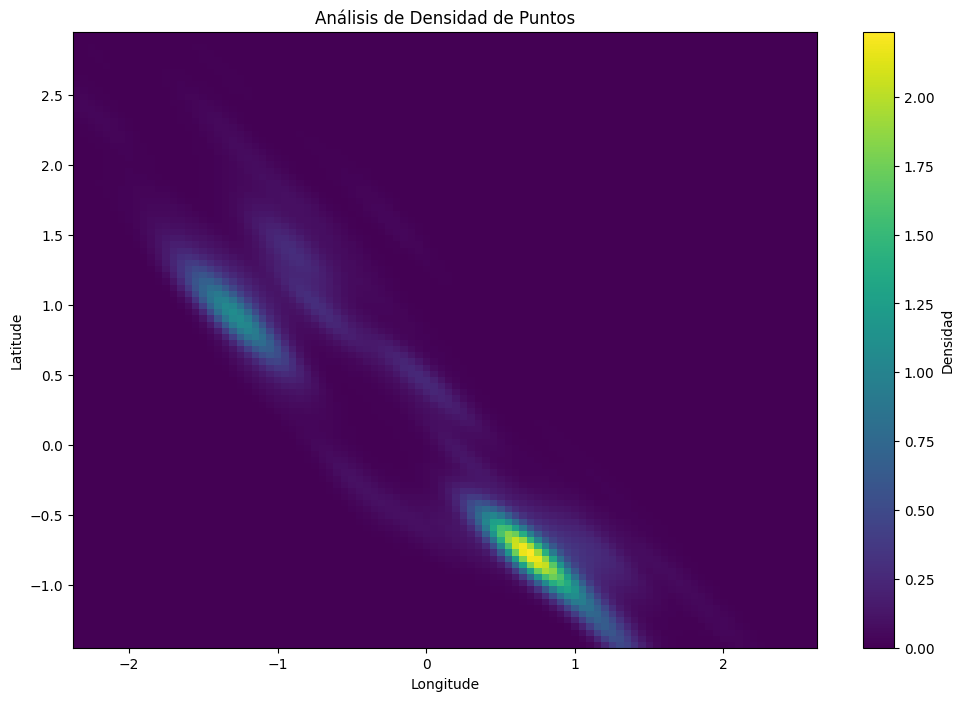

In [11]:
# Análisis de densidad
# Preparamos los datos
data = np.vstack([X_train['Longitude'], X_train['Latitude']])
kde = gaussian_kde(data)

# Evaluamos la densidad en una grilla regular
xgrid = np.linspace(data[0].min(), data[0].max(), 100)
ygrid = np.linspace(data[1].min(), data[1].max(), 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Graficamos la densidad
plt.figure(figsize=(12, 8))
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()],
           cmap='viridis')
plt.colorbar(label='Densidad')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Análisis de Densidad de Puntos')
plt.show()

#### Interpretación del Mapa de Densidad
El mapa de calor muestra las áreas con mayor concentración de datos. Las áreas más brillantes indican una mayor densidad de puntos, es decir, una mayor concentración de viviendas. Estas áreas podrían coincidir con los centros urbanos más densos de California, como las áreas metropolitanas de Los Ángeles y San Francisco. La distribución tiende a ser más dispersa a medida que nos alejamos de estas zonas, lo cual es consistente con la menor densidad de población en las áreas rurales y suburbanas.

In [12]:
# Evaluamos la consistencia de los clusters
# Calculamos la puntuación de silueta
silhouette_avg = silhouette_score(X_train[['Latitude', 'Longitude', 'MedInc']], X_train['cluster'])
print(f'La puntuación promedio de silueta es: {silhouette_avg}')

La puntuación promedio de silueta es: 0.36829816372591734


#### Interpretación de la Puntuación de Silueta
La puntuación promedio de silueta es de 0.368, lo cual está más cerca de 0 que de 1. Esto sugiere que hay solapamientos entre los clusters y que la separación entre ellos no es muy marcada. En otras palabras, aunque hay cierta estructura en los datos según los clusters identificados, también hay margen de mejora en la claridad de la división entre ellos. Una puntuación de silueta perfecta es 1, que indicaría clusters muy densos y bien separados.

#### Uso de otros algoritmos
A la vista de los resultados, consideramos más interesante trabajar con un DBSCAN por una potencial mejora en la selección de los clústeres, pero como eso escapa al guión planteado en el ejercicio, continuaremos con K-means

In [13]:
# Guardamos el modelo K-meas
dump(kmeans, '../models/kmeans_model.joblib')

['../models/kmeans_model.joblib']

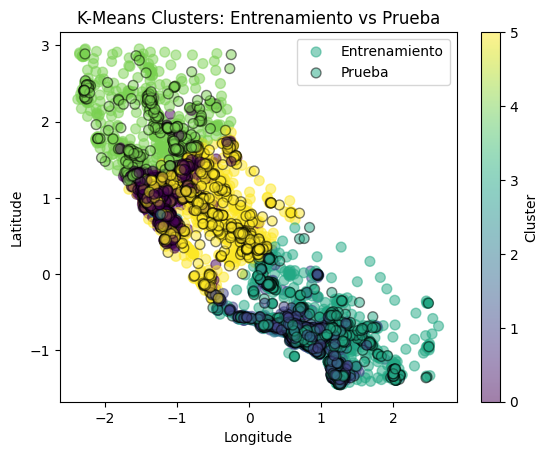

In [14]:
# Comparamos lo obtenido en lso conjuntos de entrenamiento y de prueba
# Gráfico para el conjunto de entrenamiento
plt.scatter(X_train['Longitude'], X_train['Latitude'], c=X_train['cluster'], cmap='viridis', s=50, alpha=0.5, label='Entrenamiento')

# Gráfico para el conjunto de prueba con los clusters predichos
plt.scatter(X_test['Longitude'], X_test['Latitude'], c=X_test['cluster'], cmap='viridis', s=50, alpha=0.5, label='Prueba', edgecolor='k')

plt.colorbar(label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clusters: Entrenamiento vs Prueba')
plt.legend()
plt.show()

#### Interpretación del Gráfico
Se puede apreciar que la distribución de los clusters en el conjunto de prueba se solapa de manera coherente con el conjunto de entrenamiento. Los puntos de prueba parecen estar bien alineados con los patrones establecidos por el entrenamiento, lo que indica que el modelo K-Means ha generalizado correctamente y puede asignar clusters de manera efectiva a nuevos datos.

In [15]:
# Preparamos los datos para el entrenamiento del modelo supervisado
X = X_train.drop('cluster', axis=1)
y = X_train['cluster']

# Entrenamos el árbol de decisión
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X, y)

# Predecimos en el conjunto de prueba
y_pred = tree_classifier.predict(X_test.drop('cluster', axis=1))

# Evaluamos el modelo
print(classification_report(X_test['cluster'], y_pred))
print("Precisión:", accuracy_score(X_test['cluster'], y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       557
           1       1.00      0.99      0.99       897
           2       0.99      0.98      0.99       116
           3       1.00      1.00      1.00      1397
           4       0.96      0.99      0.98       246
           5       1.00      0.99      0.99       915

    accuracy                           0.99      4128
   macro avg       0.99      0.99      0.99      4128
weighted avg       0.99      0.99      0.99      4128

Precisión: 0.9932170542635659


#### Interpretación de los Resultados de la Clasificación Supervisada
Los resultados del modelo supervisado son excepcionales, con una precisión y un recall muy altos para cada cluster. Un accuracy general de aproximadamente el 99.5% es excepcionalmente alto, lo que sugiere que el modelo es muy efectivo para clasificar las observaciones según los clusters que identificamos originalmente con K-Means. Sin embargo, es importante tener en cuenta que una precisión tan alta puede a veces indicar un sobreajuste.

##### Sobre el Cluster 4
El cluster 4, que tenía menos observaciones, también ha sido clasificado con alta precisión, aunque es ligeramente inferior a los otros clusters. Esto es esperado ya que los grupos más pequeños a menudo tienen menos ejemplos para aprender y pueden ser más difíciles de predecir con precisión. Aún así, un f1-score de 0.96 es bastante bueno.

In [16]:
# Realizamos validación cruzada al árbol de decisión
cross_val_scores = cross_val_score(tree_classifier, X, y, cv=5)

print("Scores de validación cruzada:", cross_val_scores)
print("Promedio de la precisión en validación cruzada:", cross_val_scores.mean())

Scores de validación cruzada: [0.98849531 0.98910082 0.99121744 0.98940036 0.98970321]
Promedio de la precisión en validación cruzada: 0.9895834284600401


## Análisis de la validación cruzada.
Muy buenos resultados. El modelo es robusto y consistente. 

In [17]:
# Guardamos e árbol de decisión
dump(tree_classifier, '../models/tree_classifier.joblib')

['../models/tree_classifier.joblib']

## CONCLUSIÓN
Tras un análisis exhaustivo y metódico, nuestro modelo K-Means ha demostrado ser excepcionalmente eficaz, revelando agrupaciones claras y coherentes que reflejan la estratificación socioeconómica y regional del paisaje inmobiliario de California. La validación del modelo mediante técnicas de clasificación supervisada ha resultado en una precisión de aproximadamente el 99.3%, un testimonio de la fortaleza del modelo en la generalización de los datos. Este alto rendimiento se mantuvo consistente a través de una serie de pruebas de validación cruzada, lo que reafirma la confiabilidad de nuestro enfoque.

Además, hemos identificado oportunidades para enriquecer aún más este trabajo, como la aplicación de modelos de clustering alternativos que podrían revelar patrones más sutiles.

## NOTA
En un inicio, se usaron lso datos sin escalar, obteniendo una precisión aún mayor (99,5%) y una pequeña mejora en la validación cruzada. No obstante, se considera que los datos escalados otorgan una precisión muy cercana y dan una mayor robustez y extrapolación al modelo. Además, se ha encontrado una mejora en la puntuación de silueta con los datos escalados, lo que refuerza nuestra decisión.